In [1]:
import os
def get_last_checkpoint(logdir: str):
    exps = sorted(os.listdir(logdir))

    for exp in reversed(exps):
        ckpt_path = os.path.join(logdir, exp, 'checkpoints/last.ckpt')
        if os.path.exists(ckpt_path):
            return ckpt_path

In [2]:
import hydra
from omegaconf import OmegaConf
import pyrootutils

root = pyrootutils.setup_root(".", pythonpath=True)
try:
    hydra.initialize(config_path="../configs")
except Exception as e:
    print(e)
    print("Config path already initialized!")
    pass

model_cfg = hydra.compose("../configs/model/ddpm_cifar.yaml", overrides=["+trainer.max_epochs=10"])['']['']['']['configs']['model']
# model_cfg.ckpt_path = get_last_checkpoint('../logs/train/runs')
model = hydra.utils.instantiate(model_cfg)
model.init_from_ckpt(get_last_checkpoint('../logs/train/runs'))
model = model.cuda()

/tmp/ipykernel_3408650/2473285415.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="../configs")
/work/hpc/iai/thanhtvt/.conda/envs/hoang/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/work/hpc/iai/thanhtvt/.conda/envs/hoang/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'sampler' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['sampler'])`.
  rank_zero_warn(


DDPM: Running in eps-prediction mode
Keeping EMAs of 366.
Restored from ../logs/train/runs/2023-07-29_17-25-08/checkpoints/last.ckpt with 1 missing and 8 unexpected keys
Missing Keys: ['sampler.final_alpha_cumprod']
Unexpected Keys: ['sampler.alphas_cumprod_prev', 'sampler.log_one_minus_alphas_cumprod', 'sampler.sqrt_recip_alphas_cumprod', 'sampler.sqrt_recipm1_alphas_cumprod', 'sampler.posterior_variance', 'sampler.posterior_log_variance_clipped', 'sampler.posterior_mean_coef1', 'sampler.posterior_mean_coef2']


In [3]:
import torch
torch.cuda.empty_cache()
model.sampler.set_timesteps(50)
model.sampler.eta = 0.2
model.sampler.use_clipped_model_output = True
n_samples = 9
samples = model.sample(batch_size=n_samples)

Sampling t: 100%|██████████| 50/50 [00:02<00:00, 20.54it/s]


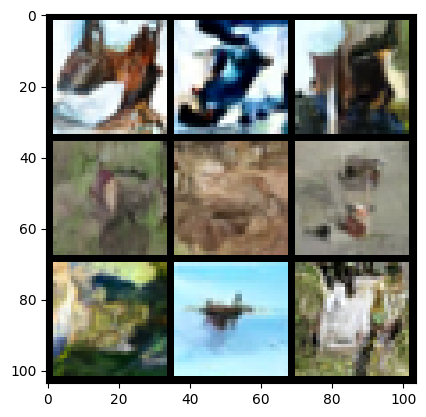

In [4]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from math import sqrt
grid = make_grid((samples.cpu() + 1) / 2, nrow=int(sqrt(n_samples)))

plt.imshow(grid.moveaxis(0, -1).numpy())